In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import glob

import sys
sys.path.append('../scripts')
import util
import ip_routines as ip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###First, load the background (reference) image and one of the process images, and subtract

Rows:  731  Cols:  892


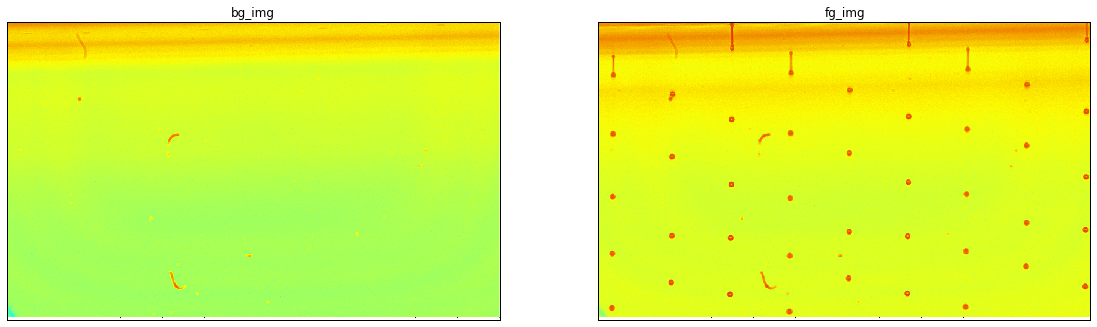

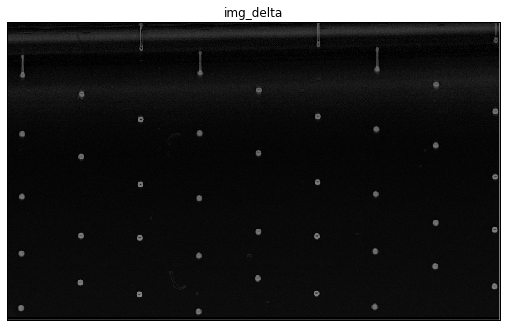

In [7]:
bg_img = cv2.imread('../images/dif/Properties_Reference/B00002.png', -1)
fg_img = cv2.imread('../images/dif/new light test 6 us_Cam_Date=160106_Time=164222/B00001.png', -1)
rows, cols, channels = bg_img.shape
print "Rows: ", rows, " Cols: ", cols

bg_img = bg_img[200:690, 0:810]  #np slice: [startY:endY, startX:endX]
#bg_img = cv2.GaussianBlur(bg_img, (5, 5), 0)
fg_img = fg_img[200:690, 0:810]  #np slice: [startY:endY, startX:endX]

bg_img_gray = cv2.cvtColor(bg_img, cv2.COLOR_BGR2GRAY)
fg_img_gray = cv2.cvtColor(fg_img, cv2.COLOR_BGR2GRAY)

thresh_val = 5
#img_delta = ip.deltaImage(bg_img, fg_img, thresh_val)
img_delta = cv2.absdiff(bg_img_gray, fg_img_gray)

#img_delta_gray = cv2.cvtColor(img_delta, cv2.COLOR_BGR2GRAY)
util.plot_imgs([(bg_img, 'bg_img'), (fg_img, 'fg_img'), (img_delta, 'img_delta')], max_cols=2, color=False)    

###Convert to HSV and separate into channels...

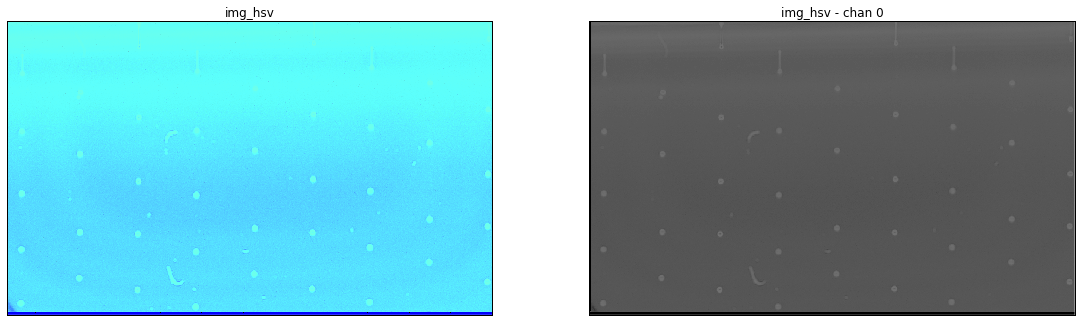

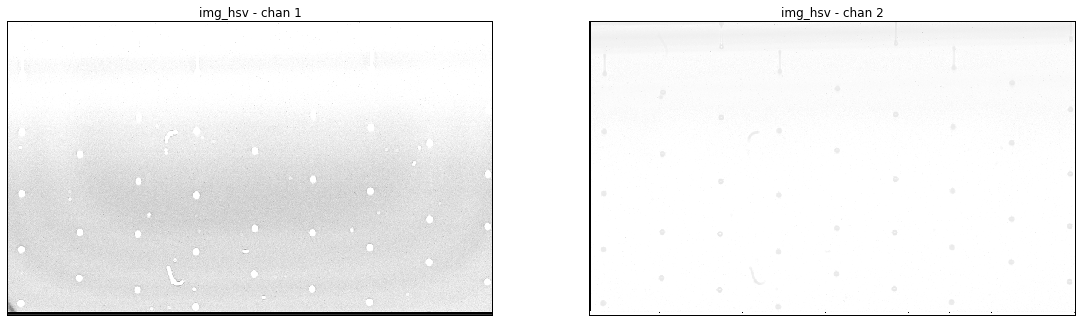

In [8]:
plot_lst = []
img_hsv = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)
plot_lst.append( (img_hsv, 'img_hsv') )

chan = ('0','1','2')
for chan_idx, chan in enumerate(chan):
    chan_img = cv2.split(img_hsv)[chan_idx]
    plot_lst.append( (chan_img, 'img_hsv - chan %d' % (chan_idx)) )
    
util.plot_imgs(plot_lst, max_cols=2)

###Looks promising.  Find some diffs between channels...

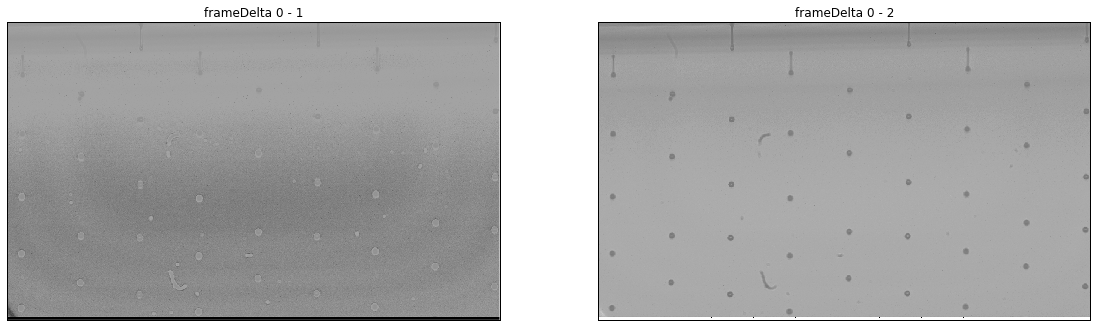

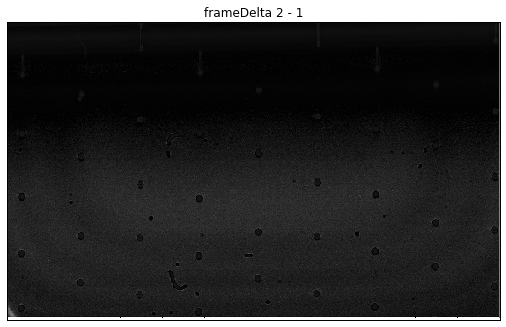

In [9]:
plot_lst = []
img_split = cv2.split(img_hsv)

frameDelta1 = cv2.absdiff(img_split[1], img_split[0])
plot_lst.append( (frameDelta1, 'frameDelta 0 - 1') )

frameDelta2 = cv2.absdiff(img_split[2], img_split[0])
plot_lst.append( (frameDelta2, 'frameDelta 0 - 2') )

frameDelta2 = cv2.absdiff(img_split[2], img_split[1])
plot_lst.append( (frameDelta2, 'frameDelta 2 - 1') )

util.plot_imgs(plot_lst, max_cols=2)

###Do the background subtraction again, but use the delta channel images
####The delta image from chan[0] and chan[2] seems to have the most information.  Lets do the image subtraction using the delta images from the background and process images.  Apply threshold and gaussian filter too...

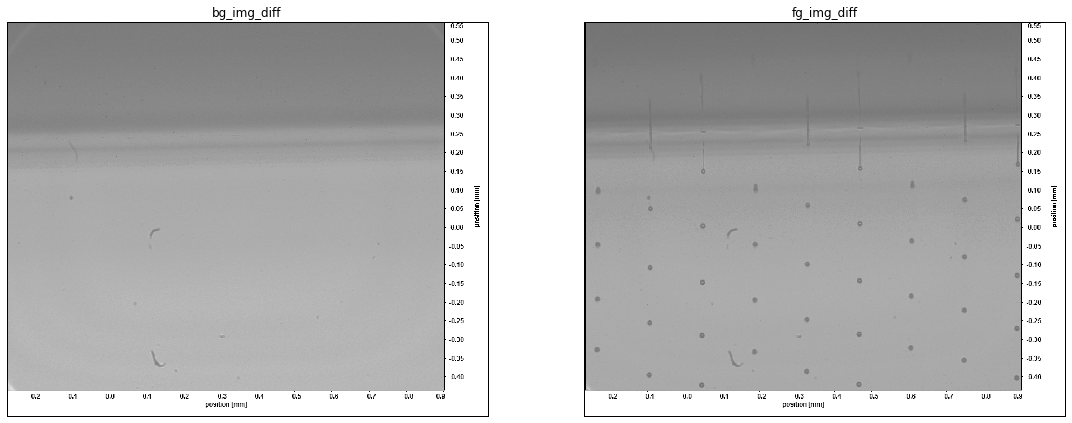

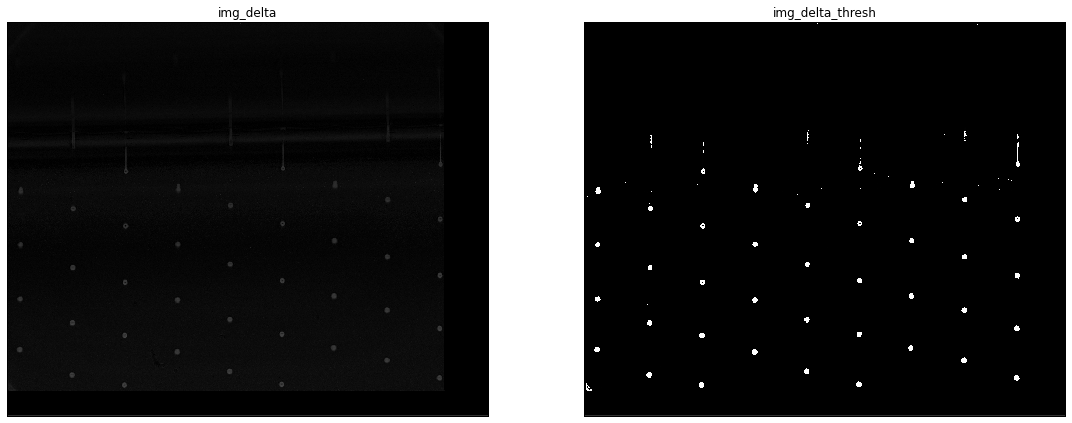

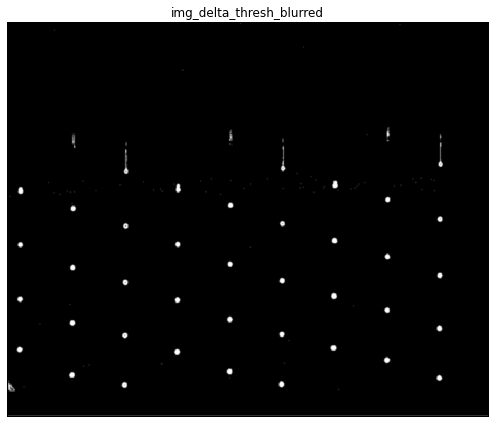

In [65]:
plot_lst = []

bg_img_hsv = cv2.cvtColor(bg_img, cv2.COLOR_BGR2HSV)
fg_img_hsv = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)

bg_img_hsv_split = cv2.split(bg_img_hsv)
fg_img_hsv_split = cv2.split(fg_img_hsv)

bg_img_diff = cv2.absdiff(bg_img_hsv_split[2], bg_img_hsv_split[0])
plot_lst.append( (bg_img_diff, 'bg_img_diff') )

fg_img_diff = cv2.absdiff(fg_img_hsv_split[2], fg_img_hsv_split[0])
plot_lst.append( (fg_img_diff, 'fg_img_diff') )

img_delta = cv2.absdiff(bg_img_diff, fg_img_diff)
plot_lst.append( (img_delta, 'img_delta') )

thresh_val = 25
kernel_size = 5

ret,img_delta_thresh = cv2.threshold(img_delta, thresh_val, 255, cv2.THRESH_BINARY)
plot_lst.append( (img_delta_thresh,'img_delta_thresh') )

img_delta_thresh_blurred = cv2.GaussianBlur(img_delta_thresh, (kernel_size, kernel_size), 0)
plot_lst.append( (img_delta_thresh_blurred,'img_delta_thresh_blurred') )

util.plot_imgs(plot_lst, max_cols=2)

###Define callable function of above stack 

In [11]:
def preprocess_image(bg_img, fg_img, thresh_val, kernel_size):
    bg_img_hsv = cv2.cvtColor(bg_img, cv2.COLOR_BGR2HSV)
    fg_img_hsv = cv2.cvtColor(fg_img, cv2.COLOR_BGR2HSV)

    bg_img_hsv_split = cv2.split(bg_img_hsv)
    fg_img_hsv_split = cv2.split(fg_img_hsv)

    bg_img_diff = cv2.absdiff(bg_img_hsv_split[2], bg_img_hsv_split[0])
    fg_img_diff = cv2.absdiff(fg_img_hsv_split[2], fg_img_hsv_split[0])

    img_delta = cv2.absdiff(bg_img_diff, fg_img_diff)

    ret,img_delta_thresh = cv2.threshold(img_delta, thresh_val, 255, cv2.THRESH_BINARY)
    img_delta_thresh_blurred = cv2.GaussianBlur(img_delta_thresh, (kernel_size, kernel_size), 0)
    return img_delta_thresh_blurred

###Run the stack on folder of images...

Num imgs:  20
[0] Num drops found: 40
 [00-00] X: 217, Y: 647, Rad: 5.00
 [00-01] X: 605, Y: 577, Rad: 5.00
 [00-02] X: 604, Y: 668, Rad: 5.00
 [00-03] X: 607, Y: 376, Rad: 4.00
 [00-04] X: 509, Y: 553, Rad: 5.00
 [00-05] X: 220, Y: 359, Rad: 5.00
 [00-06] X: 511, Y: 463, Rad: 4.00
 [00-07] X: 121, Y: 551, Rad: 5.00
 [00-08] X: 218, Y: 554, Rad: 4.00
 [00-09] X: 121, Y: 421, Rad: 4.00
 [00-10] X: 508, Y: 646, Rad: 4.00
 [00-11] X: 218, Y: 467, Rad: 5.00
 [00-12] X: 413, Y: 415, Rad: 4.00
 [00-13] X: 704, Y: 530, Rad: 5.00
 [00-14] X: 314, Y: 676, Rad: 5.00
 [00-15] X: 122, Y: 319, Rad: 4.00
 [00-16] X: 412, Y: 622, Rad: 5.00
 [00-17] X: 803, Y: 347, Rad: 4.00
 [00-18] X: 316, Y: 382, Rad: 4.00
 [00-19] X: 023, Y: 580, Rad: 5.00
 [00-20] X: 706, Y: 302, Rad: 4.00
 [00-21] X: 704, Y: 602, Rad: 4.00
 [00-22] X: 023, Y: 487, Rad: 4.00
 [00-23] X: 316, Y: 584, Rad: 4.00
 [00-24] X: 119, Y: 628, Rad: 5.00
 [00-25] X: 316, Y: 490, Rad: 5.00
 [00-26] X: 022, Y: 670, Rad: 5.00
 [00-27] X: 413, 

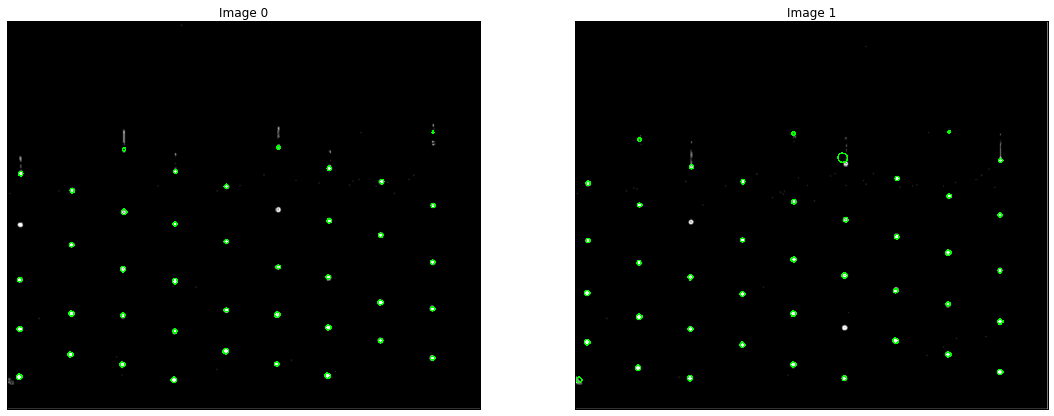

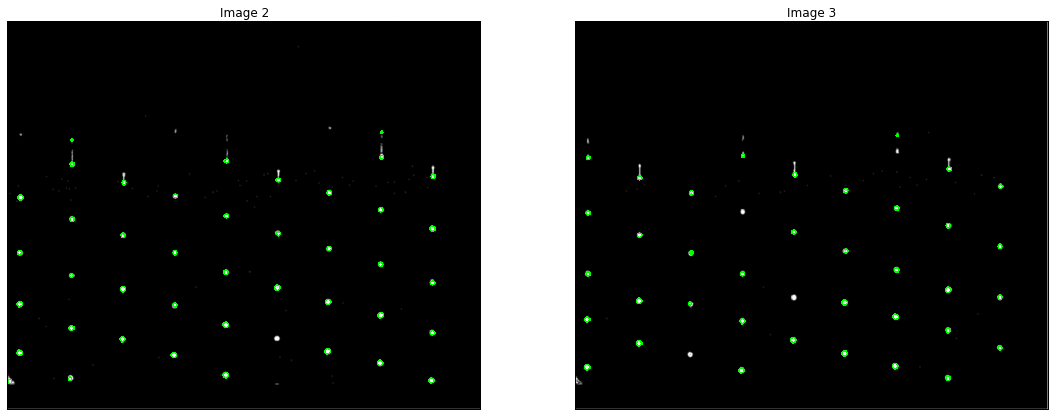

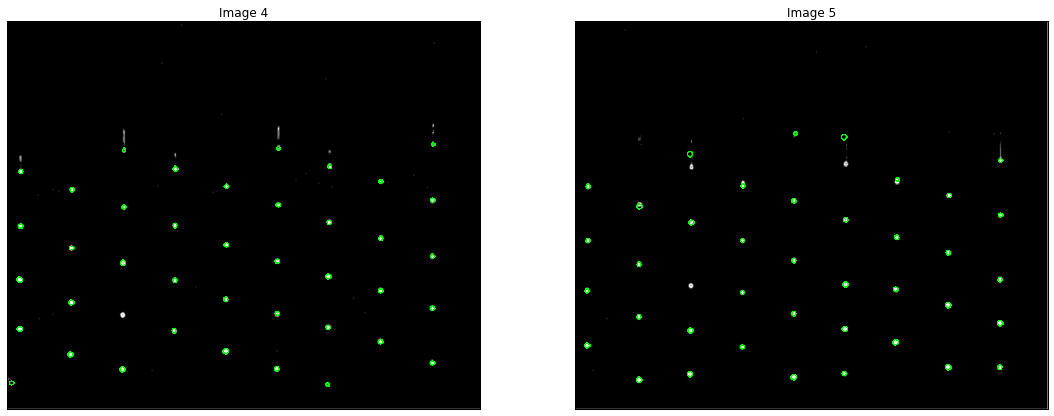

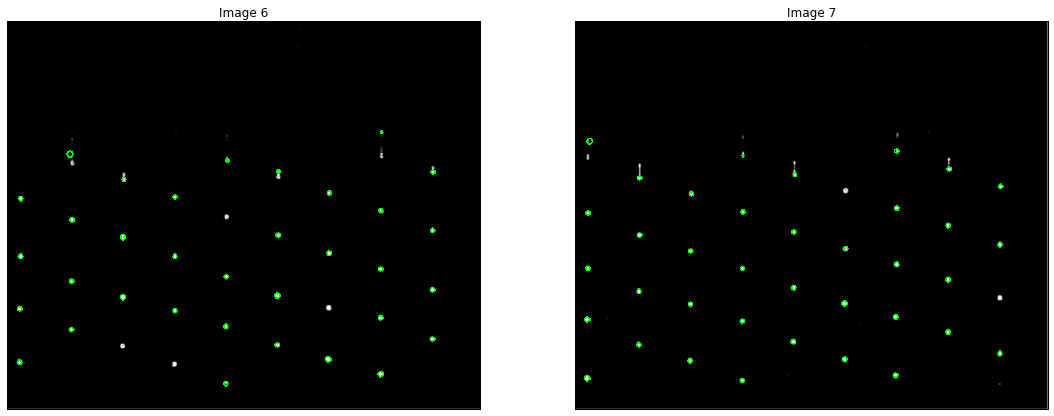

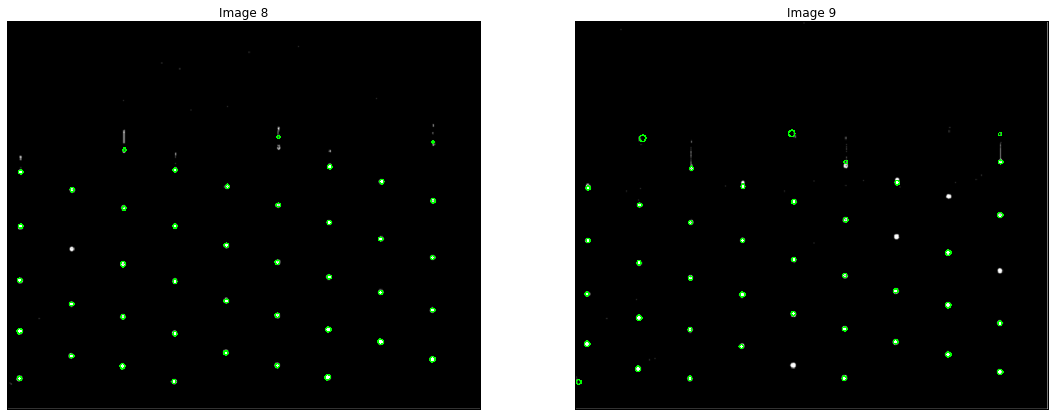

In [66]:
plot_lst = []
bg_img = cv2.imread('../images/dif/Properties_Reference/B00002.png', -1)

image_folder_lst = ['../images/dif/new light test 6 us_Cam_Date=160106_Time=164222']
file_spec = 'B*.png'
fg_img_lst = util.Image_List(image_folder_lst, file_spec, doSort=True, overlay=None, color=True)

print "Num imgs: ", fg_img_lst.cnt()

delay_s = 0.01
verbose = True
thresh_val = 30
kernel_size = 5

for idx, fg_img in enumerate(fg_img_lst.images[0:10]):
    img_delta_thresh_blurred = preprocess_image(bg_img, fg_img, thresh_val, kernel_size)
    #plot_lst.append( (img_delta_thresh_blurred, 'img %d' % (idx)) )
    #plot_lst.append( (fg_img, 'img %d' % (fg_img_lst.idx())) )

    #contour_img, contours, hierarchy = cv2.findContours(img_delta_thresh_blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #plot_lst.append( (contour_img,'contour_img') )
    circles = cv2.HoughCircles(img_delta_thresh_blurred, cv2.HOUGH_GRADIENT,1.5,45,
                            param1=100,param2=10,minRadius=0,maxRadius=10)
    print("[%d] Num drops found: %d" %(idx,len(circles[0,:])))
    
    cimg = cv2.cvtColor(img_delta_thresh_blurred,cv2.COLOR_GRAY2BGR)
    circles = np.uint16(np.around(circles))
    for idx2, i in enumerate(circles[0,:]):
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        print(" [%02d-%02d] X: %03d, Y: %03d, Rad: %3.2f" % (idx, idx2, i[0],i[1],i[2]))
        # draw the center of the circle
        #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    plot_lst.append( (cimg, 'Image %d' % (idx)) )

util.plot_imgs(plot_lst, max_cols=2)
